In [ ]:
!git clone https://github.com/taoxugit/AttnGAN.git

fatal: destination path 'AttnGAN' already exists and is not an empty directory.


In [ ]:
!wget text_encoder.pth https://saai-factory-assets.s3.us-west-2.amazonaws.com/attgan/text_encoder.pth
!wget netG_epoch.pth https://saai-factory-assets.s3.us-west-2.amazonaws.com/attgan/netG_epoch_40.pth
!wget captions.pickle https://saai-factory-assets.s3.us-west-2.amazonaws.com/attgan/captions.pickle

--2021-09-06 17:04:34--  http://text_encoder.pth/
Resolving text_encoder.pth (text_encoder.pth)... failed: Name or service not known.
wget: unable to resolve host address ‘text_encoder.pth’
--2021-09-06 17:04:34--  https://saai-factory-assets.s3.us-west-2.amazonaws.com/attgan/text_encoder.pth
Resolving saai-factory-assets.s3.us-west-2.amazonaws.com (saai-factory-assets.s3.us-west-2.amazonaws.com)... 52.218.136.217
Connecting to saai-factory-assets.s3.us-west-2.amazonaws.com (saai-factory-assets.s3.us-west-2.amazonaws.com)|52.218.136.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52247233 (50M) [application/x-www-form-urlencoded]
Saving to: ‘text_encoder.pth.1’

text_encoder.pth.1  100%[===================>]  49.83M  31.2MB/s    in 1.6s    

2021-09-06 17:04:36 (31.2 MB/s) - ‘text_encoder.pth.1’ saved [52247233/52247233]

FINISHED --2021-09-06 17:04:36--
Total wall clock time: 2.1s
Downloaded: 1 files, 50M in 1.6s (31.2 MB/s)
--2021-09-06 17:04:37--  http:

In [ ]:
import sys
import torch
import pickle 
import numpy as np
from PIL import Image
sys.path.append('/content/AttnGAN/code/')

from miscc.config import cfg, cfg_from_file
from model import RNN_ENCODER, G_NET
from torch.autograd import Variable


In [ ]:
# load configuration
cfg.GAN.DF_DIM = 96
cfg.GAN.GF_DIM = 48
cfg.GAN.Z_DIM = 100
cfg.GAN.R_NUM = 3
cfg.TEXT.EMBEDDING_DIM = 256
cfg.TRAIN.NET_E = '/content/text_encoder.pth'
cfg.TRAIN.NET_G = '/content/netG_epoch_40.pth'
cfg.CUDA = True

In [ ]:
def models(word_len):
  # Load Text Encoder
  text_encoder = RNN_ENCODER(word_len, nhidden=cfg.TEXT.EMBEDDING_DIM)
  state_dict = torch.load(cfg.TRAIN.NET_E, map_location=lambda storage, loc: storage)
  text_encoder.load_state_dict(state_dict)
  if cfg.CUDA:
    text_encoder.cuda()
  text_encoder.eval()

  # Load Generator
  netG = G_NET()
  state_dict = torch.load(cfg.TRAIN.NET_G, map_location=lambda storage, loc: storage)
  netG.load_state_dict(state_dict)
  if cfg.CUDA:
    netG.cuda()
  netG.eval()

  return text_encoder, netG

def word_index():
  with open('/content/captions.pickle', 'rb') as f:
    x = pickle.load(f)
  ixtoword, wordtoix = x[2], x[3]
  
  return wordtoix, ixtoword

def vectorize_caption(wordtoix, caption, copies=2):
    # create caption vector
    tokens = caption.split(' ')
    cap_v = []
    for t in tokens:
        t = t.strip().encode('ascii', 'ignore').decode('ascii')
        if len(t) > 0 and t in wordtoix:
            cap_v.append(wordtoix[t])

    # expected state for single generation
    captions = np.zeros((copies, len(cap_v)))
    for i in range(copies):
        captions[i,:] = np.array(cap_v)
    cap_lens = np.zeros(copies) + len(cap_v)

    return captions.astype(int), cap_lens.astype(int)

def generate(caption, wordtoix, ixtoword, text_encoder, netG , copies=2):
    # load word vector
    captions, cap_lens  = vectorize_caption(wordtoix, caption, copies)
    n_words = len(wordtoix)

    # only one to generate
    batch_size = captions.shape[0]

    nz = cfg.GAN.Z_DIM
    captions = Variable(torch.from_numpy(captions), volatile=True)
    cap_lens = Variable(torch.from_numpy(cap_lens), volatile=True)
    noise = Variable(torch.FloatTensor(batch_size, nz), volatile=True)

    if cfg.CUDA:
        captions = captions.cuda()
        cap_lens = cap_lens.cuda()
        noise = noise.cuda()

    

    #######################################################
    # (1) Extract text embeddings
    #######################################################
    hidden = text_encoder.init_hidden(batch_size)
    words_embs, sent_emb = text_encoder(captions, cap_lens, hidden)
    mask = (captions == 0)
        

    #######################################################
    # (2) Generate fake images
    #######################################################
    noise.data.normal_(0, 1)
    fake_imgs, attention_maps, _, _ = netG(noise, sent_emb, words_embs, mask)

    
    # G attention
    cap_lens_np = cap_lens.cpu().data.numpy()

    generated_imgs = []
    for j in range(batch_size):
      for k in range(len(fake_imgs)):
          im = fake_imgs[k][j].data.cpu().numpy()
          im = (im + 1.0) * 127.5
          im = im.astype(np.uint8)
          im = np.transpose(im, (1, 2, 0))
          im = Image.fromarray(im)
          generated_imgs.append(im)
          
    return generated_imgs

In [ ]:
wordtoix, _ = word_index()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/content/Att

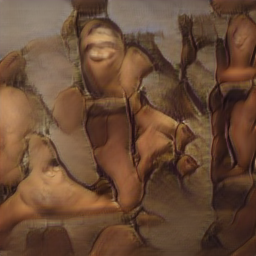

In [ ]:
cancer_text = ["Cancer is a complex disease","I had a feeding tube for six months","Cancer doesn’t care who we are","cancers are very annoying","cancer is a horrible disease","I really hope we find a way to treat cancer effectively soon","We stand together to fight the deadly disease of Cancer","People die from cancer","Rest In Peace","suffering from cancer disease"]
covid_text = ["COVID vaccination","covid is gonna be forever","inability to see their loved ones because of covid","covid is so toxic","covid affect my mental and stress me","I’m mad because of covid","I’m upset","It's okay to fear a lockdown","It's okay to be confused","It's okay to be frustrated"]
Alzheimer_text = ["Support the fight to end Alzheimer","I struggle with Alzheimer's disease","it makes me disappointment","feel frustration","Alzheimer's is a growing epidemic","how I will live with Alzheimer","Many of our friends have started to distance themselves","The Alzheimer's was having an impact","Alzheimer’s can be so rough","I miss my father who suffer from Alzheimer"]
# load word dictionaries
wordtoix, ixtoword = word_index()
# load models
text_encoder, netG = models(len(wordtoix))
# Change it based on the text you want
for i in range(len(cancer_text)):
  generated_imgs = generate(caption, wordtoix, ixtoword, text_encoder, netG)
  generated_imgs[2]